In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import os
import json
import torch
import math
import torch.nn as nn
from einops import rearrange

In [ ]:
# gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')
gpt2_large = GPT2LMHeadModel.from_pretrained('gpt2-large')
tokenizer_large = GPT2Tokenizer.from_pretrained('gpt2-large')

In [ ]:
#print(vars(gpt2).keys())
#print(vars(gpt2)['config'])
# "n_ctx": 1024,
# "n_embd": 768,
# "n_head": 12,
# "n_inner": null,
# "n_layer": 12,
# "n_positions": 1024,

print(vars(gpt2_large)['config'])
# "n_ctx": 1024,
# "n_embd": 1280,
# "n_head": 20,
# "n_inner": null,
# "n_layer": 36,
# "n_positions": 1024,

In [1]:
!python download_dataset.py

^C


In [2]:
import os
import sys
import requests
from tqdm import tqdm

subdir = 'data'
if not os.path.exists(subdir):
    os.makedirs(subdir)
subdir = subdir.replace('\\','/') # needed for Windows

for ds in [
    # 'webtext', 'small-117M',  
    # 'small-117M-k40',
    # 'medium-345M', 'medium-345M-k40',
    'large-762M', # todo-later  
    # 'large-762M-k40',
    # 'xl-1542M',    'xl-1542M-k40',
]:
    for split in ['train', 'valid', 'test']:
        filename = ds + "." + split + '.jsonl'
        r = requests.get("https://openaipublic.azureedge.net/gpt-2/output-dataset/v1/" + filename, stream=True)

        with open(os.path.join(subdir, filename), 'wb') as f:
            file_size = int(r.headers["content-length"])
            chunk_size = 1000
            with tqdm(ncols=100, desc="Fetching " + filename, total=file_size, unit_scale=True) as pbar:
                # 1k for chunk_size, since Ethernet packet size is around 1500 bytes
                for chunk in r.iter_content(chunk_size=chunk_size):
                    f.write(chunk)
                    pbar.update(chunk_size)

Fetching large-762M.train.jsonl: 753Mit [03:33, 3.53Mit/s]                                          
Fetching large-762M.valid.jsonl: 14.9Mit [00:02, 6.54Mit/s]                                         
Fetching large-762M.test.jsonl: 15.0Mit [00:02, 5.94Mit/s]                                          


# baseline.py

In [1]:
import os
import json
import numpy as np
from scipy import sparse

from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer


def _load_split(data_dir, source, split, n=np.inf):
    path = os.path.join(data_dir, f'{source}.{split}.jsonl')
    texts = []
    for i, line in enumerate(open(path)):
        if i >= n:
            break
        texts.append(json.loads(line)['text'])
    return texts

def load_split(data_dir, source, split, n=np.inf):
    webtext = _load_split(data_dir, 'webtext', split, n=n//2)
    gen = _load_split(data_dir, source, split, n=n//2)
    texts = webtext+gen
    labels = [0]*len(webtext)+[1]*len(gen)
    return texts, labels

def main(data_dir, log_dir, source='xl-1542M-k40', n_train=500000, n_valid=10000, n_jobs=None, verbose=False):
    train_texts, train_labels = load_split(data_dir, source, 'train', n=n_train)
    valid_texts, valid_labels = load_split(data_dir, source, 'valid', n=n_valid)
    test_texts, test_labels = load_split(data_dir, source, 'test')

    vect = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_features=2**21)
    train_features = vect.fit_transform(train_texts)
    valid_features = vect.transform(valid_texts)
    test_features = vect.transform(test_texts)

    model = LogisticRegression(solver='liblinear')
    params = {'C': [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64]}
    split = PredefinedSplit([-1]*n_train+[0]*n_valid)
    search = GridSearchCV(model, params, cv=split, n_jobs=n_jobs, verbose=verbose, refit=False)
    search.fit(sparse.vstack([train_features, valid_features]), train_labels+valid_labels)
    model = model.set_params(**search.best_params_)
    model.fit(train_features, train_labels)
    valid_accuracy = model.score(valid_features, valid_labels)*100.
    test_accuracy = model.score(test_features, test_labels)*100.
    data = {
        'source':source,
        'n_train':n_train,
        'valid_accuracy':valid_accuracy,
        'test_accuracy':test_accuracy
    }
    print(data)
    json.dump(data, open(os.path.join(log_dir, f'{source}.json'), 'w'))

In [4]:
!pip install fire

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 88.3/88.3 kB 830.2 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116933 sha256=bf87f1a7035100b694d9c5fcce83d438088e1bf1ff713b58a7ca95342c255568
  Stored in directory: c:\users\cmsr-m3\appdata\local\pip\cache\wheels\f7\f1\89\b9ea2bf8f80ec027a88fef1d354b3816b4d3d29530988972f6
Successfully built fire


In [8]:
!python run_entropy.py --source webtext --split train


100%|██████████| 32/32 [00:33<00:00,  1.05s/it]


In [1]:
# sources = ['webtext', 'small-117M',  'small-117M-k40',
#         'medium-345M', 'medium-345M-k40',
#         'large-762M',  'large-762M-k40',
#         'xl-1542M',    'xl-1542M-k40',
# ]
sources = [
        'xl-1542M',    'xl-1542M-k40'
]
splits = ['train', 'valid', 'test']

for source in sources:
    for split in splits:
        !python run_entropy.py --source {source} --split {split}






100%|██████████| 32/32 [04:45<00:00,  8.94s/it]



100%|██████████| 32/32 [03:05<00:00,  5.80s/it]

100%|██████████| 32/32 [04:35<00:00,  8.61s/it]

100%|██████████| 32/32 [05:13<00:00,  9.81s/it]

100%|██████████| 32/32 [04:21<00:00,  8.19s/it]

100%|██████████| 32/32 [04:58<00:00,  9.31s/it]


# Data distribution
500k samples in  total, 250k human-generated, 250k machine-generated

In [2]:
data_dir = 'data/'
source = 'small-117M'
n_train = 500000
n_valid=10000
train_texts, train_labels = load_split(data_dir, source, 'train', n=n_train)
valid_texts, valid_labels = load_split(data_dir, source, 'valid', n=n_valid)
test_texts, test_labels = load_split(data_dir, source, 'test')

# vect = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_features=2**21)
# train_features = vect.fit_transform(train_texts)
# valid_features = vect.transform(valid_texts)
# test_features = vect.transform(test_texts)

# model = LogisticRegression(solver='liblinear')
# params = {'C': [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64]}
# split = PredefinedSplit([-1]*n_train+[0]*n_valid)
# search = GridSearchCV(model, params, cv=split, n_jobs=n_jobs, verbose=verbose, refit=False)
# search.fit(sparse.vstack([train_features, valid_features]), train_labels+valid_labels)
# model = model.set_params(**search.best_params_)
# model.fit(train_features, train_labels)
# valid_accuracy = model.score(valid_features, valid_labels)*100.
# test_accuracy = model.score(test_features, test_labels)*100.
# data = {
#     'source':source,
#     'n_train':n_train,
#     'valid_accuracy':valid_accuracy,
#     'test_accuracy':test_accuracy
# }
# print(data)
# json.dump(data, open(os.path.join(log_dir, f'{source}.json'), 'w'))

In [3]:
len_list = list()
human_len_list = list()
machine_len_list = list()
for i, train_text in enumerate(train_texts):
    num_spaces = train_text.count(" ") + 1
    len_list.append(num_spaces)
    if train_labels[i] == 0:
        machine_len_list.append(num_spaces)
    else:
        human_len_list.append(num_spaces)
print(f"Max sample length:{max(len_list)}")
print(f"Mean sample length:{np.mean(len_list)}")
print(f"Max sample length for machine:{max(machine_len_list)}")
print(f"Mean sample length for machine:{np.mean(machine_len_list)}")
print(f"Max sample length for human:{max(human_len_list)}")
print(f"Mean sample length for human:{np.mean(human_len_list)}")

Max sample length:1024
Mean sample length:451.263752
Max sample length for machine:1018
Mean sample length for machine:424.414408
Max sample length for human:1024
Mean sample length for human:478.113096


Max sample length:1024
Mean sample length:451.263752
Max sample length for machine:1018
Mean sample length for machine:424.414408
Max sample length for human:1024
Mean sample length for human:478.113096


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


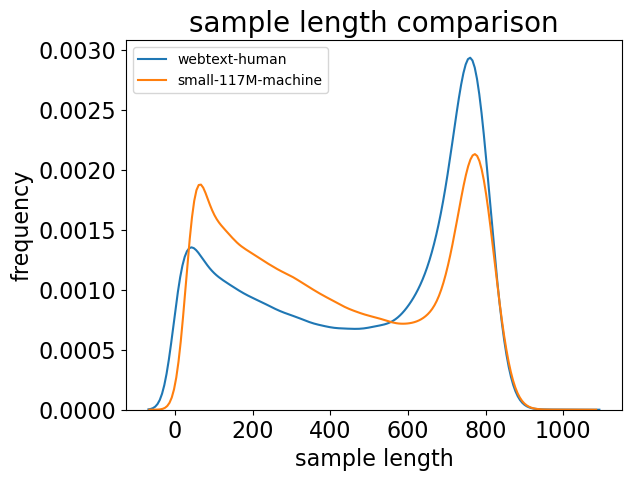

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

len_list = list()
human_len_list = list()
machine_len_list = list()
for i, train_text in enumerate(train_texts):
    num_spaces = train_text.count(" ") + 1
    len_list.append(num_spaces)
    if train_labels[i] == 0:
        machine_len_list.append(num_spaces)
    else:
        human_len_list.append(num_spaces)
print(f"Max sample length:{max(len_list)}")
print(f"Mean sample length:{np.mean(len_list)}")
print(f"Max sample length for machine:{max(machine_len_list)}")
print(f"Mean sample length for machine:{np.mean(machine_len_list)}")
print(f"Max sample length for human:{max(human_len_list)}")
print(f"Mean sample length for human:{np.mean(human_len_list)}")

#sns.distplot(human_len_list) #绘制密度直方图

# Plot the first set of data
sns.distplot(human_len_list, hist=False, kde=True, label='webtext-human')

# Plot the second set of data
sns.distplot(machine_len_list, hist=False, kde=True, label='small-117M-machine')

plt.xlabel("sample length", fontsize=16)
plt.ylabel("frequency", fontsize=16)
plt.xticks(fontsize=16)                  #设置x轴刻度值的字体大小
plt.yticks(fontsize=16)                  #设置y轴刻度值的字体大小
plt.title("sample length comparison", fontsize=20)            #设置子图标题
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Plot the histogram
plt.hist(human_len_list, bins=range(min(human_len_list), max(human_len_list) + 2, 100), align='left', rwidth=0.8)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Histogram of Values')

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Example data
data = [1, 2, 3, 4, 4, 4, 5, 5, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8]

# Plot the histogram
plt.hist(data, bins=range(min(data), max(data) + 2), rwidth=0.8)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Histogram of Values')

# Display the plot
plt.show()

In [ ]:
train_texts[:5]

In [ ]:
print(vars(gpt2_large).keys())
# print(gpt2_large._modules)

In [ ]:
# From https://github.com/huggingface/transformers/issues/18282
print(gpt2_large._modules['transformer'].wte.weight.requires_grad)
print(type(gpt2_large._modules['transformer']))
print(type(gpt2_large.transformer))
print(len(gpt2_large.transformer.h))
print(gpt2_large.lm_head)
print(gpt2_large.lm_head.weight.requires_grad)

In [ ]:
print(type(gpt2_large.base_model))
print(type(gpt2_large.base_model.parameters()))
print(type(gpt2_large.base_model.named_parameters()))

# The following demo of named parameters are from https://github.com/huggingface/transformers/blob/v4.24.0/src/transformers/models/gpt2/modeling_gpt2.py#L667
# for name, p in gpt2_large.base_model.named_parameters():
#     print(name)

# We can notice that wte.weight and lm_head are actually shared parameters
print(torch.equal(gpt2_large.lm_head.weight,
                    gpt2_large.transformer.wte.weight))
# The two tensors are equal

In [ ]:
# from: https://huggingface.co/transformers/v4.5.1/training.html
trainable_params_count = 0
frozen_params_count = 0
total_params_count = 0
for param in gpt2_large.base_model.parameters():
    if param.requires_grad:
        trainable_params_count += 1
    else:
        frozen_params_count += 1
    total_params_count += 1
    # print(param.requires_grad)

print('total params #:', total_params_count)
print('trainable params #:', trainable_params_count)
print('frozen params #:', frozen_params_count)

In [ ]:
gpt2_large.lm_head.weight.requires_grad = False
print(gpt2_large.transformer.h[-1])

print(gpt2_large._modules['transformer'].wte.weight.requires_grad)
print(gpt2_large.lm_head.weight.requires_grad)

In [ ]:
def _load_split_bykey(data_dir, source, split, key='text', n=np.inf):
    path = os.path.join(data_dir, f'{source}.{split}.jsonl')
    data = []
    for i, line in enumerate(open(path)):
        if i >= n:
            break
        data.append(json.loads(line)[key])
    return data

In [ ]:
# webtext_train = _load_split_bykey('data/', 'webtext', 'train', key='text')
webtext_train_lens = _load_split_bykey('data/', 'webtext', 'train', key='length')

In [ ]:
print(max(webtext_train_lens))
# no problem, <= n_positions == 1024

In [ ]:
# Examine degen data
def _load_degen_data(data_dir: str, filename: str, n=np.inf, return_type='json'):
    path = os.path.join(data_dir, filename)
    data = []
    for i, line in enumerate(open(path, 'r')):
        if i >= n:
            break
        try:
            obj = json.loads(line)
        except Exception:
            print(line)
            raise

        if return_type == 'json':
            data.append(obj)
        else:
            data.append(obj['string'])

    return data

In [ ]:
lines = _load_degen_data('data/data_degen/unconditional', 'unconditional_gold.jsonl', n=1)
line1 = lines[0]

In [ ]:
print(len(line1['tokens']))

In [ ]:
line1_encoded = tokenizer_large(line1['string'], return_tensors='pt')

In [ ]:
line1_encoded['input_ids']

In [ ]:
torch.equal(torch.tensor(line1['tokens'], dtype=torch.long), line1_encoded['input_ids'].squeeze())
# line1['tokens'] and line1_encoded['input_ids'] are equal

In [ ]:
line1_output = gpt2_large(**line1_encoded, labels=line1_encoded['input_ids'])

In [ ]:
print(line1_output.loss)

In [ ]:
math.exp(line1_output.loss.item())

In [ ]:
logits = line1_output.logits
target = line1_encoded['input_ids']
logits = rearrange(logits, 'B L V -> B V L')

shift_logits = logits[..., :-1]
shift_target = target[..., 1:]

In [ ]:
criterian = nn.NLLLoss(reduction='none')
log_softmax = nn.LogSoftmax(dim=1)

In [ ]:
with torch.no_grad():
    nll_loss = criterian(log_softmax(shift_logits), shift_target).squeeze()

In [ ]:
print(nll_loss)
print(nll_loss.size())

In [ ]:
print(line1['nll4tok'])

In [ ]:
with torch.no_grad():
    nll_loss2 = criterian(log_softmax(logits), target).squeeze()

In [ ]:
print(nll_loss2)